In [41]:
import numpy as np
from object_detection_helper import GeneratorMultipleOutputs, plot_batch

In [42]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)
target_size=(256, 256)

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']


In [43]:
from keras.applications.vgg16 import VGG16

In [44]:
from keras.layers import Dense, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, Conv2D, Dropout
from keras.models import Model

In [45]:
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))

In [46]:
modelVGG16.layers[6].name

'block2_pool'

In [47]:
modelVGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [48]:
# Esto es igual que antes
flatten_output = Flatten(name='Flatten_1')(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))
dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))

In [49]:
# Saco de la capa 6
n_classes = len(classes)
GAP_output = Flatten(name='Flatten_2')(Conv2D(kernel_size=1, filters=32, name='Conv_1x1')(modelVGG16.layers[10].output))
dense_3_output = Activation('relu')(Dense(128, name = 'Dense_3')(GAP_output))
dense_4_output = Activation('relu')(Dense(128, name = 'Dense_4')(dense_3_output))

In [50]:
from keras.layers import Concatenate

In [51]:
# Concateno
conc = Concatenate(name='concatenated_outputs')([dense_2_output, dense_4_output])

In [52]:
# Capas de predicción
n_classes = len(classes)
class_prediction = Dense(n_classes, activation='softmax', name='category_output')(conc)
bbox_prediction = Dense(4, name='bounding_box')(Dropout(0.5)(conc))
model = Model(inputs=modelVGG16.input, outputs=[class_prediction, bbox_prediction])

In [53]:
N_trainable = 17
print('primer capa entrenable:', model.layers[17].name)

for layer in model.layers[:N_trainable]:
    layer.trainable = False
for layer in model.layers[N_trainable:]:
    layer.trainable = True

primer capa entrenable: block5_conv3


In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [55]:
from custom_losses import IOU_loss, iou

In [56]:
losses = {"category_output": "categorical_crossentropy", 
          "bounding_box": "mean_squared_error"
          #"bounding_box": IOU_loss
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, IOU_loss]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  20.0,
              }

In [57]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 50, classes = classes,
                                                            concat_output = False,
                                                            flip = 'random',
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 50, classes = classes,
                                                              concat_output = False,
                                                              flip = 'random',
                                                          target_size=target_size
                                                         )

Found 1250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [63]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='bounding_box_IOU_loss', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.0001),
              metrics=metrics,
              loss_weights = lossWeights)

In [64]:
from object_detection_helper import PlotLosses

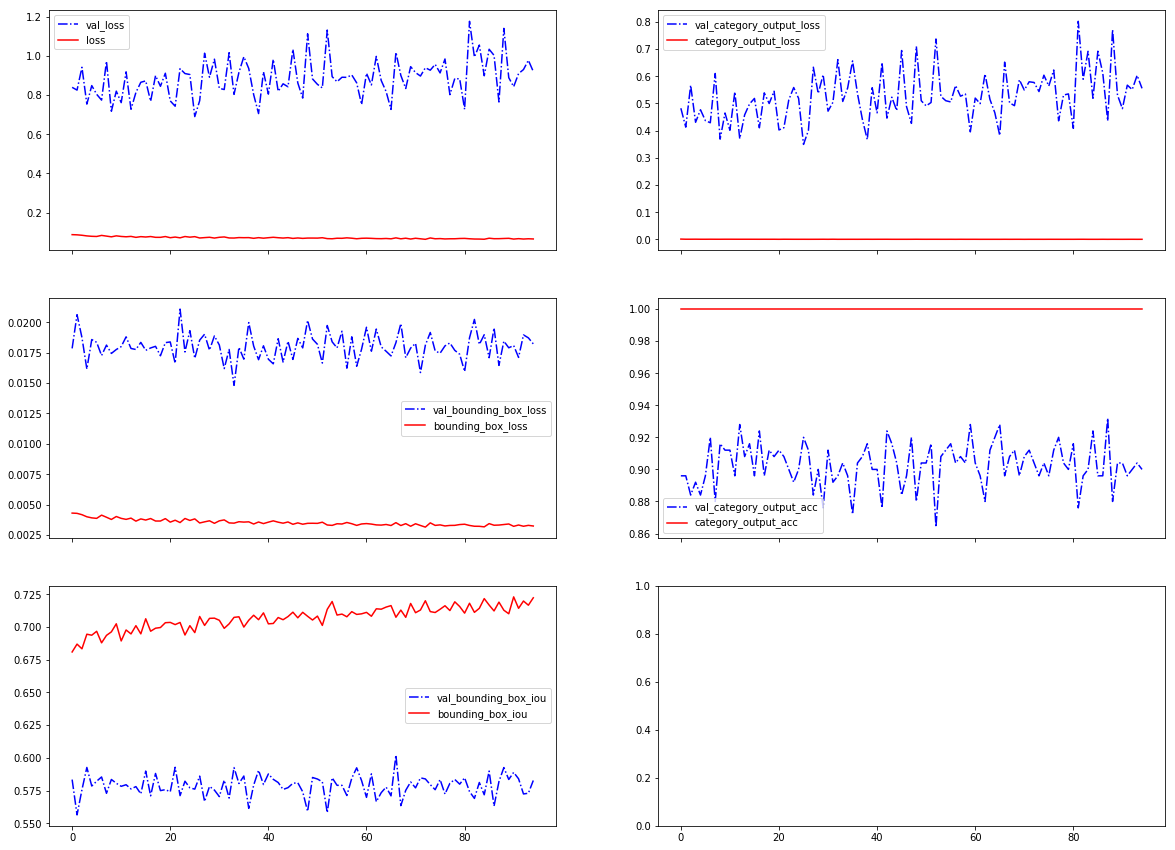

Epoch 96/200
 9/25 [=========>....................] - ETA: 2s - loss: 0.0711 - category_output_loss: 4.0095e-04 - bounding_box_loss: 0.0035 - category_output_acc: 1.0000 - bounding_box_iou: 0.7100 - bounding_box_IOU_loss: 0.2900

KeyboardInterrupt: 

In [65]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [161]:
model.load_weights('runtime_best.hdf5')

In [162]:
model.evaluate_generator(val_generator_multiple_outputs)

[0.7612743020057678,
 0.1292196505703032,
 0.03160273320972919,
 0.971999990940094,
 0.4754733145236969,
 0.5245266675949096]